In [1]:
import numpy as np
import pandas as pd
print(pd.__version__)
from pandas import DataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='serif')

import datetime
from datetime import date, time, datetime

import ephem

import astropy.constants 
from astropy import physical_constants, astronomical_constants
#from astropy.constants import R_sun, R_jup
import astropy.units as u

import astropy.coordinates
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, get_moon
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()

import scipy

import math
from statistics import stdev

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

import csv
import re
import requests
import sys
import ipydatetime
 
from ALL_FUNCTIONS import depth_filter, transit_predictor, split_distributions, get_refined, target_selector, sun_moon_tracking, find_astrotwi, observability, unc_filter, dec_visible



0.25.0


In [2]:
# FETCH NASA EXOPLANET DATA FROM DATABASE #
api_url = 'https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&select=ra,dec,pl_hostname,pl_name,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_radj,st_rad,pl_eqt,pl_trandep,pl_trandur,rowupdate,pl_ttvflag&order=pl_tranmid&where=pl_discmethod%20like%20%27%25Transit%25%27'
response = requests.get(api_url)
if response.status_code != 200:
    print('Failed to get data:', response.status_code)
else:
    data_API = pd.read_csv(api_url)
    df = DataFrame(data_API, columns=['ra', 'dec', 'pl_hostname', 'pl_name' , 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_radj', 'st_rad', 'pl_eqt', 'pl_trandep', 'pl_trandur', 'rowupdate', 'pl_ttvflag'])
    df = df[df['pl_orbper'].notna()] #removes any target with no orbital period entry
    df = df[df['pl_orbpererr1'].notna()] #removes any target with no orbital period error entry
    df = df[df['pl_name'].notna()] #removes any target with no name entry
    df = df[df['pl_tranmiderr1'].notna()] #removes any target with no transit midpoint minus error entry
    df = df[df['pl_tranmid'].notna()] #removes any target with no transit midpoint entry
    df = df[df['pl_tranmiderr2'].notna()] #removes any target with no transit midpoint plus error entry
    df = df[df['pl_trandur'].notna()]
    df = df[df['pl_radj'].notna()]
    df = df[df['st_rad'].notna()]
    df = df.reset_index(drop=True)
#print(df)
print(len(df)) 

# list of transit detections 
data_detected = pd.read_csv("DETECTIONS.csv")
df_detect = DataFrame(data_detected, columns=['Planet Name', 'Midpoint', 'Plus Error', 'Minus Error'])

# list of non detections - csv with planetname, start of obs and end of obs
data_non = pd.read_csv('NON_DETECTIONS.csv')
df_non = DataFrame(data_non, columns=['Planet Name', 'Start', 'End'])


2524


# Code running order
- (1) Load the API and create the database
- (2) Run DEPTH_FILTER to remove all unobservable planets - gives index, name, percentage depth and factor above threshold
- (3) Run sun_moon_tracking to create the sun and the moon for the observation date and find the start and end of astronomical twilight.
- (4) Run target_selector and/or transit_predictor (not sure which) to identify which targets have a midpoint occuring during this time on the observation date.
- (5) Run observability to find which targets are visible during this time from the users location.

# This stuff makes the Juypter widgets

In [3]:
#make widgets 
style = {'description_width': 'initial'}
rb = widgets.RadioButtons(options=['No Detection', 'Transit Detected'], value=None)
button1 = widgets.Button(description='Upload Parameters', layout=widgets.Layout(width='30%', height='50px'), disabled=False, button_style='info', icon='space-shuttle')
button2 = widgets.Button(description='Upload Raw Data', layout=button1.layout, disabled=False, button_style='info', icon='rocket')
sub_button = widgets.Button(description='Submit', layout=widgets.Layout(width='20%', height='30%', left='79%'), disabled=False, button_style='danger' )
sub_button2 = widgets.Button(description='Submit', layout=sub_button.layout, disabled=False, button_style='danger' )
sub_button3 = widgets.Button(description='Submit', layout=sub_button.layout, disabled=False, button_style='danger' ) 
start_date = widgets.DatePicker(description='Start of Obs:')
start_time = ipydatetime.TimePicker()
end_date = widgets.DatePicker(description='End of Obs:')
end_time = ipydatetime.TimePicker()
start = widgets.HBox(children=[start_date, start_time])
end = widgets.HBox(children=[end_date, end_time])
date = widgets.DatePicker(description='Date of obs:')
long = widgets.BoundedFloatText(value = -1.9, min = -180, max = 180, description='Longitude (deg):', style=style)
lat = widgets.BoundedFloatText(value = 52.4, min = -90, max = 90, description='Latitude (deg):', style=style)
alt = widgets.FloatText(value = 140, description='Altitude (m):', style=style)
utc_offset = widgets.BoundedFloatText(value = +1, min=-12, max=+12, step=0.5, description='UTC \pm offset:', style=style)
out=widgets.Output()

above_box = widgets.HBox(children = [button1, button2])
top_toggle = widgets.VBox(children = [rb])
left_box = widgets.VBox()
right_box = widgets.VBox()
below_box = widgets.HBox([left_box, right_box])
bottom = widgets.VBox() 
input_ = widgets.HBox([widgets.VBox(children = [long, lat, alt]), widgets.VBox(children=[date, utc_offset, sub_button3])])


tab1 = widgets.VBox(children=[widgets.Label(value="Select a target exoplanet to observe."), widgets.Label(value='Please enter your coordinates and when you will observe.'), widgets.Label(value='Current coordinates are set for the University of Birmingham Wast Hills Observatory.'), input_])
tab2 = widgets.VBox(children=[widgets.Label(value="Did you detect a transit in your observations?"), above_box, bottom])
tab = widgets.Tab(children=[tab1, tab2])
tab.set_title(0, 'Find a Target')
tab.set_title(1, 'Record Observation')


midpoint = widgets.Text(value = 'Julian Days', description='Midpoint of Transit:', continuous_update = False, style=style)
err_plus = widgets.Text(value = 'days', description = 'Plus error:', continuous_update = False)
err_minus = widgets.Text(value='days', description = 'Minus error:', continuous_update = False)
period = widgets.Text(value='None', description = 'Orbital Period', continuous_update = False)
errper_plus = widgets.Text(value = 'None', description = 'Plus error', continuous_update = False)
errper_minus = widgets.Text(value = 'None', description = 'Minus error', continuous_update = False)
names = df['pl_name'].tolist()
name = widgets.Combobox(placeholder='planet name', options=names, description='Name of Target Planet:', ensure_option=True, style=style)


#programme buttons
def parameters(button):
    bottom.children = [top_toggle, below_box]
    
button1.on_click(parameters)

def raw_data(button):
    bottom.children = [widgets.Label(value='Function to fit lightcurve will go here.')]

button2.on_click(raw_data)


def detect_or_not(button):
    
    if button['new']:
        if rb.value == 'Transit Detected': 
            left_box.children = [name, midpoint, err_plus, err_minus]
            right_box.children = [period, errper_plus, errper_minus, sub_button]
            print()
        else:
            left_box.children = [name, start, end]
            right_box.children = [period, errper_plus, errper_minus, sub_button2]


rb.observe(detect_or_not, names='value')

def add_to_dataframe(a):
    if name.value in names:
        print(float(midpoint.value))
        new_row = {'Planet Name':name.value, 'Midpoint':midpoint.value, 'Plus Error':err_plus.value, 'Minus Error':err_minus.value}
        new_df = df_detect.append(new_row, ignore_index=True)
        new_df.to_csv(r"DETECTIONS.csv") 
        print('Thank you for submitting your data!')
        display(new_df)

    
        print('Updated transits for',name.value)
    
        name_indexNASA = df.index[df['pl_name'] == name.value].to_list()
        if period.value == 'None' or errper_plus.value == 'None' or errper_minus.value == 'None':
            orb_per = df['pl_orbper'][name_indexNASA].item()
            err_per1 = df['pl_orbpererr1'][name_indexNASA].item()
            err_per2 = abs(df['pl_orbpererr2'][name_indexNASA].item())
            transit_predictor(float(midpoint.value), float(err_plus.value), float(err_minus.value), orb_per, err_per1, err_per2, 2459058.656, 2459166.721, False)
        else:
            transit_predictor(float(midpoint.value), float(err_plus.value), float(err_minus.value), float(period.value), float(errper_plus.value), float(errper_minus.value), 2459058.656, 2459166.721, False)

    else: 
        print('please enter a valid planet name')
        
        
sub_button.on_click(add_to_dataframe)


def submit_nondetection(a):
    if name.value in names:
        start = ' '.join([str(start_date.value), str(start_time.value)])
        end = ' '.join([str(end_date.value), str(end_time.value)])
        t_start = Time(start, format='iso')
        t_end = Time(end, format='iso')
        JD_end = t_end.jd
        JD_start = t_start.jd
        new_row = {'Planet Name':name.value, 'Start':JD_start, 'End':JD_end}
        new_df = df_stend.append(new_row, ignore_index=True)
        new_df.to_csv(r"tool_stend.csv")
        print('Thank you for submitting your data!')
        display(new_df)
    else:
        print('please enter a valid planet name')
    
    
sub_button2.on_click(submit_nondetection)


def color_negative_red(value):
    if value[0] < 0.02:
        color = 'green'
    elif value[0] > 0.02:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

def find_target(a):
    # run depth_filter to reduce NASA API to only planets with sufficient depth to be observed.
    # Returns indices of these planets in df['pl_name'].tolist(). 
    d = depth_filter(df['pl_name'].tolist(), df['pl_radj'].tolist(), df['st_rad'].tolist())
    indices = d[0]
    
    # filter out any targets not observable because of their declination
    dec_vis = dec_visible(indices, df['dec'].tolist(), float(lat.value))
    new_indices = dec_vis[0]
    
    # run sun_moon_tracking to find start and end of astronomical twilight on the input observing date
    S_and_M = sun_moon_tracking(long = float(long.value), lat = float(lat.value), alt = float(alt.value), date = str(date.value), utc_offset = float(utc_offset.value))
    delta_midnight = S_and_M[0]
    moon = S_and_M[1]
    moon_altaz = S_and_M[2]
    sun_altaz = S_and_M[3]
    
    asttwi = find_astrotwi(long = float(long.value), lat = float(lat.value), date = str(date.value))
    UTC_AT_beg = asttwi[0]
    UTC_AT_end = asttwi[1]
    #Local_AT_beg = ephem.localtime(UTC_AT_beg) #uses your CURRENT location - so if were in Vegas this should work
    #Local_AT_end = ephem.localtime(UTC_AT_end) #uses your CURRENT location - so if were in Vegas this should work
    Local_AT_beg = ephem.Date(UTC_AT_beg + float(utc_offset.value)*ephem.hour)
    Local_AT_end = ephem.Date(UTC_AT_end + float(utc_offset.value)*ephem.hour)
    
    print('The start and end of Astronomical Twilight is')
    print(UTC_AT_beg, 'to', UTC_AT_end, 'UTC') #outputs are in UTC
    print(Local_AT_beg, 'to', Local_AT_end, 'local time') #outputs in USERS local time
    print('The night is', (UTC_AT_end-UTC_AT_beg)*24, 'hours long')
    
    #convert beginning and end to JD
    t_begin = Time(str(ephem.Date(str(UTC_AT_beg)).datetime()), format='iso', scale='utc')
    t_end = Time(str(ephem.Date(str(UTC_AT_end)).datetime()), format='iso', scale='utc')
    JD_begin = t_begin.jd
    JD_end = t_end.jd    
    
    # run target_selector to find all transiting planets which are observable on this date and calculate when 
    # their midpoints are. Writes data to observable_targets.csv.
    # target_selector uses JD_begin and JD_end
    m = target_selector(new_indices, df['pl_name'][new_indices].tolist(), df['pl_tranmid'][new_indices].tolist(), df['pl_tranmiderr1'][new_indices].tolist(), df['pl_tranmiderr2'][new_indices].tolist(), df['pl_orbper'][new_indices].tolist(), df['pl_orbpererr1'][new_indices].tolist(), df['pl_orbpererr2'][new_indices].tolist(), JD_begin, JD_end)
    observable = pd.read_csv("observable_targets.csv")
    df_obs = DataFrame(observable, columns=['Name', 'Midpoint', 'Plus Error', 'Minus Error', 'Size in interval'])
    #display(df_obs)
    
    planet = m[0]
    midpoints = m[1]
    pluserrs = m[2]
    minuserrs = m[3]
    sizes = m[4]
    total = m[5]
    proportion = m[6]
    indices = m[7]
 
    # filter out any transits with uncertainty larger than 30mins
    U_FILTER = unc_filter(indices, planet, pluserrs, minuserrs)
    new_indices = U_FILTER
    
    print(f'The observability function will iterate through {len(new_indices)} planets')

    NAMES = []
    VIS_FLAGS = []
    NASA_INDEX = []
    START = []
    JD_START = []
    END = []
    JD_END = []
    VIS_TIME = []
    PERC = []
   
    for i in new_indices:
        ra = df['ra'][i]
        dec = df['dec'][i]
        name = df['pl_name'][i]
        
    ### AT THE MOMENT, TARGETS THAT NEVER RISE ABOVE +20 deg HAVE START AND END TIMES OF ZERO (0) ###
        OBS = observability(i, name, ra, dec, float(long.value), float(lat.value), float(alt.value), str(date.value), utc_offset, S_and_M[0], S_and_M[1], S_and_M[2], S_and_M[3])
        if OBS[4] == 'NaN':
            pass
        else:
            NAMES.append(OBS[0])
            VIS_FLAGS.append(OBS[1])
            START.append(OBS[2])        #START is in UTC time, with iso format: YYYY-MM-DD hh:mm:ss.fff
            JD_START.append(OBS[2].jd)
            END.append(OBS[3])          #END is in UTC time, with iso format: YYYY-MM-DD hh:mm:ss.fff
            JD_END.append(OBS[3].jd)
            NASA_INDEX.append(OBS[4])
            PERC.append(OBS[5])
            VIS_TIME.append(OBS[6])     #has dataype TimeDelta
    
    #get the midpoints, errors and sizes for observable planets
    mid_index = []
    for i in range(len(NASA_INDEX)):
        for j in range(len(indices)):
            if NASA_INDEX[i] == indices[j]:
                mid_index.append(j)
    
    # NASA_INDEX gives position in the API of final targets after they have been passed through observability.
    # Midpoints were calculated before observability filtered out more targets so mid_index is used to fetch the 
    # midpoints and errors (ONLY) which correspond to the right NASA indices.
    
    MIDPOINTS = [midpoints[i] for i in mid_index] #these values are in JD
    #MIDPOINTS = [(midpoints[i].format = 'iso') for i in mid_index] #these values are in iso UTC
    TWO_SIG_START = [(midpoints[i]-2*minuserrs[i]) for i in mid_index] 
    TWO_SIG_END = [(midpoints[i]+2*pluserrs[i]) for i in mid_index]
    TWO_SIG_WIN_LEN = [(2*minuserrs[i]+2*pluserrs[i])*24 for i in mid_index]
    PLUS = [2*pluserrs[i] for i in mid_index]
    PLUS_R = [round(num, 4) for num in PLUS]
    MINUS = [2*minuserrs[i] for i in mid_index]
    MINUS_R = [round(num, 4) for num in MINUS]
    TOTAL_UNC = [f'+ {PLUS_R[i]}\n - {MINUS_R[i]}' for i in range(len(PLUS_R))]
    SIZE = [sizes[i] for i in mid_index]
    TOTAL = [total[i] for i in mid_index] 
    PROP = [proportion[i] for i in mid_index]
    PERIOD = df['pl_orbper'][NASA_INDEX]
    DURATION = df['pl_trandur'][NASA_INDEX]
    
    def merit_func(period, total_unc, transit_duration, total_obs_length):
        RANK = []
        score_per = period
        score_unc = total_unc / 30
        score_dur = (float(str(total_obs_length)) / float(transit_duration))
        #score_sci = 
        #select ONLY planets that have a total_obs_length > transit_duration
        if float(transit_duration) > float(str(total_obs_length)):
            score = 0
            RANK.append(score)
        else:
            #score = score + W_TD*(total_obs_length / transit_duration) + W_UNC*(total_unc/30) + W_PER*(period)
            score = score_dur + score_unc + score_per
            RANK.append(score)
        return RANK
    
    SCORE = []
    for i in range(len(NASA_INDEX)):
        Period = df['pl_orbper'][NASA_INDEX[i]]
        Total_Unc = np.abs(PLUS[i])+np.abs(MINUS[i])
        Total_unc_minutes = Total_Unc*24*60
        Duration = df['pl_trandur'][NASA_INDEX[i]]*24 #duration in hours
        #print(f'The transit duration of planet {NASA_INDEX[i]} is {Duration}')
        Total_Obs = str(VIS_TIME[i])
        MF = merit_func(Period, Total_unc_minutes, float(Duration), float(Total_Obs))
        SCORE.append(MF[0])            
    
    
    data_final = list(zip(NAMES, PERIOD, DURATION, TWO_SIG_START, MIDPOINTS, TWO_SIG_END, TOTAL_UNC, TWO_SIG_WIN_LEN, VIS_TIME, PROP, SCORE)) 
    df_final = pd.DataFrame(data_final, columns=["Planet Name", "Period (days)", "Transit Duration (Days)", "Start of 2sigma window (JD)", "Midpoint of Transit (JD)", "End of 2sigma window (JD)", "Uncertainty on Midpoint (Days)", "Length of 2sigma window (Hours)", "Visible (Hours)", "Percentage of Total Points in Window", "Score"])
    #df_final.style.applymap(color_negative_red, subset=['Plus Error on Midpoint (Days)','Minus Error on Midpoint (Days)'])
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    def pretty_print(df_final):
        return display(HTML(df_final.to_html().replace("\\n","<br>")))
    
    pd.set_option('display.max_rows', None)
    pretty_print(df_final)
    
    sort_by_score = df_final.sort_values('Score',ascending=False)
    Sorted = sort_by_score.head(n=10)
    pretty_print(Sorted)

    
sub_button3.on_click(find_target)

display(tab)

### CURRENT RUNTIME FROM HITTING THE SUBMIT BUTTON IS <2min 40sec FOR DATE ENTRY 30/08/2020 ###
### ATM TOTAL UNC DOMINATES THE SCORE - test date 20/08/2020 to see this. 

In [4]:
#cut by percentage of points in window ??? - ie below 90% ???
#promte long period objects - these can be observed less frequently
#promote targets that can have the full 2sigma window observed
#promote objects with large uncertainities - these need observing first ideally


# CONVERSION BETWEEN DATES EXAMPLE #
today = date.today()
now = today.strftime("%Y-%m-%d %H:%M:%S")
t = Time(now, format='iso', scale='utc')
print(f'Todays date is {t}.')
t.format = 'jd'
print(f'Todays Julian date is {t}.')
#jd_today = t.jd

# WIDGETS TESTING GROUND #

In [5]:
### WIDGETS TESTING GROUND ###
widgets.FloatSlider(
    value=7.5,
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

widgets.Box(
    [
        widgets.Label(value='Pizza topping with a very long label:'),
        widgets.RadioButtons(
            options=[
                'pepperoni',
                'pineapple',
                'anchovies',
                'and the long name that will fit fine and the long name that will fit fine and the long name that will fit fine '
            ],
            layout={'width': 'max-content'}
        )
    ]
)

Box(children=(Label(value='Pizza topping with a very long label:'), RadioButtons(layout=Layout(width='max-cont…

# UTC AND LOCAL TIME TESTING GROUND #

<SkyCoord (AltAz: obstime=['2020-08-18 11:59:59.999' '2020-08-18 12:05:59.999'
 '2020-08-18 12:11:59.999' '2020-08-18 12:17:59.999'
 '2020-08-18 12:23:59.999' '2020-08-18 12:29:59.999'
 '2020-08-18 12:35:59.999' '2020-08-18 12:41:59.999'
 '2020-08-18 12:47:59.999' '2020-08-18 12:53:59.999'
 '2020-08-18 12:59:59.999' '2020-08-18 13:05:59.999'
 '2020-08-18 13:11:59.999' '2020-08-18 13:17:59.999'
 '2020-08-18 13:23:59.999' '2020-08-18 13:29:59.999'
 '2020-08-18 13:35:59.999' '2020-08-18 13:41:59.999'
 '2020-08-18 13:47:59.999' '2020-08-18 13:53:59.999'
 '2020-08-18 13:59:59.999' '2020-08-18 14:05:59.999'
 '2020-08-18 14:11:59.999' '2020-08-18 14:17:59.999'
 '2020-08-18 14:23:59.999' '2020-08-18 14:29:59.999'
 '2020-08-18 14:35:59.999' '2020-08-18 14:41:59.999'
 '2020-08-18 14:47:59.999' '2020-08-18 14:53:59.999'
 '2020-08-18 14:59:59.999' '2020-08-18 15:05:59.999'
 '2020-08-18 15:11:59.999' '2020-08-18 15:17:59.999'
 '2020-08-18 15:23:59.999' '2020-08-18 15:29:59.999'
 '2020-08-18 15:35:5

Local midnight occurs at 2020-08-18 23:59:59.999 and in UTC this is 2020-08-19 06:59:59.999
Astronomical twilight and night occurs between 2020-08-18 11:59:59.999 and 2020-08-19 11:59:59.999 local time
Astronomical twilight and night occurs between 2020-08-19 10:29:59.999 and 2020-08-19 18:59:59.999 UTC


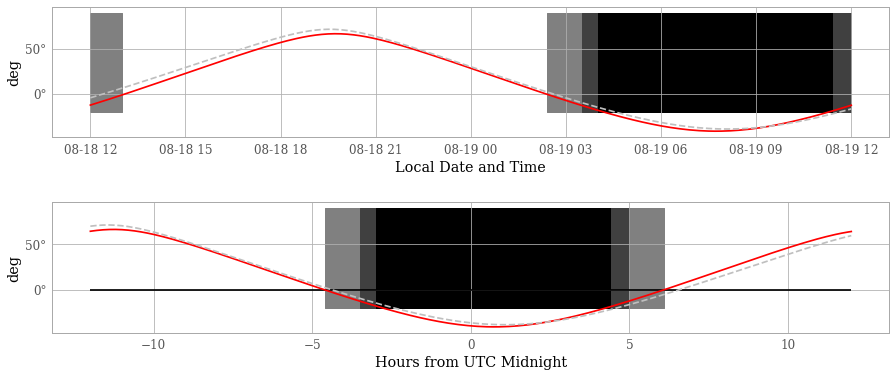

<SkyCoord (AltAz: obstime=['2020-08-18 11:59:59.999' '2020-08-18 12:05:59.999'
 '2020-08-18 12:11:59.999' '2020-08-18 12:17:59.999'
 '2020-08-18 12:23:59.999' '2020-08-18 12:29:59.999'
 '2020-08-18 12:35:59.999' '2020-08-18 12:41:59.999'
 '2020-08-18 12:47:59.999' '2020-08-18 12:53:59.999'
 '2020-08-18 12:59:59.999' '2020-08-18 13:05:59.999'
 '2020-08-18 13:11:59.999' '2020-08-18 13:17:59.999'
 '2020-08-18 13:23:59.999' '2020-08-18 13:29:59.999'
 '2020-08-18 13:35:59.999' '2020-08-18 13:41:59.999'
 '2020-08-18 13:47:59.999' '2020-08-18 13:53:59.999'
 '2020-08-18 13:59:59.999' '2020-08-18 14:05:59.999'
 '2020-08-18 14:11:59.999' '2020-08-18 14:17:59.999'
 '2020-08-18 14:23:59.999' '2020-08-18 14:29:59.999'
 '2020-08-18 14:35:59.999' '2020-08-18 14:41:59.999'
 '2020-08-18 14:47:59.999' '2020-08-18 14:53:59.999'
 '2020-08-18 14:59:59.999' '2020-08-18 15:05:59.999'
 '2020-08-18 15:11:59.999' '2020-08-18 15:17:59.999'
 '2020-08-18 15:23:59.999' '2020-08-18 15:29:59.999'
 '2020-08-18 15:35:5

Local midnight occurs at 2020-08-18 23:59:59.999 and in UTC this is 2020-08-18 22:59:59.999
Astronomical twilight and night occurs between 2020-08-18 20:53:59.999 and 2020-08-19 03:29:59.999 local time
Astronomical twilight and night occurs between 2020-08-18 19:53:59.999 and 2020-08-19 02:29:59.999 UTC


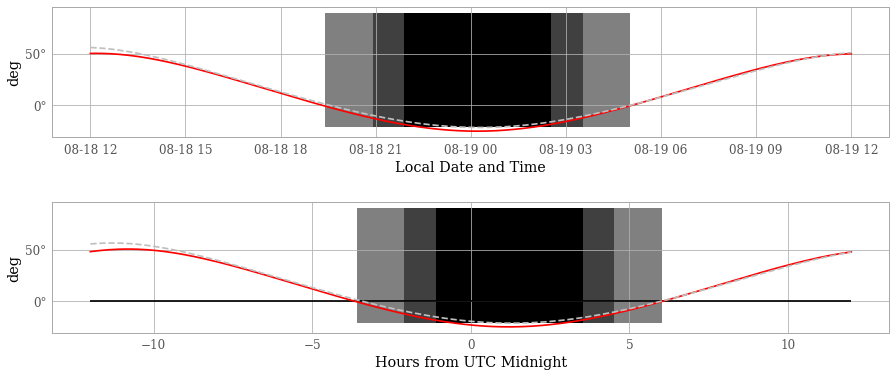

In [6]:
# TRYING TO GET LOCAL TIME TO WORK # 
def sun_moon_tracking(long, lat, alt, date, utc_offset):
    #location = EarthLocation(long, lat, height) #NOTE: West longitudes are negative
    location = EarthLocation(long*u.deg, lat*u.deg, height = alt*u.m)    
    delta_midnight = np.linspace(-12, 12, 241)*u.hour 
    #gives 1 data point every 6mins - each value in the list has dtype: float64
    local_midnight = Time(f'{date} 23:59:59.999') 
    local_frame_night = AltAz(obstime=local_midnight+delta_midnight, location=location) 
    local_moon = get_moon(local_midnight+delta_midnight)
    local_moon_altaz = local_moon.transform_to(local_frame_night)
    local_sun_altaz = get_sun(local_midnight+delta_midnight).transform_to(local_frame_night)
    print(local_sun_altaz)
    
    local_frame_night_times = []
    for j in range(0, len(delta_midnight)):
        LCT = local_frame_night.obstime[j].value
        LT = datetime.strptime(LCT, "%Y-%m-%d %H:%M:%S.%f")#.time()
        local_frame_night_times.append(LT)
    
    local_sun_indexlist = []
    for i in range(0, len(local_sun_altaz)):
        if local_sun_altaz[i].alt.degree < -12: #ie IF astronomical twilight or astronomical night
            local_sun_indexlist.append(i)
        else:
            pass
    #print(local_sun_indexlist[0])
    local_ast_twi_beg = local_sun_altaz[local_sun_indexlist[0]].obstime 
    local_ast_twi_end = local_sun_altaz[local_sun_indexlist[-1]].obstime 
    local_ast_twi_times = [local_ast_twi_beg, local_ast_twi_end]
    
    
    
    utc_midnight = local_midnight - utc_offset*u.hour 
    utc_frame_night = AltAz(obstime=utc_midnight+delta_midnight, location=location) 
    #list of times from 15:59:59 til 07:59:59 and list containing location in m, temp, humidity etc
    utc_moon = get_moon(utc_midnight+delta_midnight)
    utc_moon_altaz = utc_moon.transform_to(utc_frame_night)
    utc_sun_altaz = get_sun(utc_midnight+delta_midnight).transform_to(utc_frame_night)
    #sun and moon have format:  SkyCoord YYYY-MM-DD hh:mm:ss.sss
    #                                    ra(deg), dec(deg), distance(AU)
    #sun_altaz has format:      SkyCoord YYYY-MM-DD hh:mm:ss.sss
    #                                    az(deg), alt(deg), distance(m)
    utc_sun_indexlist = []
    for i in range(0, len(utc_sun_altaz)):
        if utc_sun_altaz[i].alt.degree < -12: #ie IF astronomical twilight or astronomical night
            utc_sun_indexlist.append(i)
        else:
            pass
    utc_ast_twi_beg = utc_sun_altaz[utc_sun_indexlist[0]].obstime - utc_offset*u.hour
    utc_ast_twi_end = utc_sun_altaz[utc_sun_indexlist[-1]].obstime - utc_offset*u.hour
    utc_ast_twi_times = [utc_ast_twi_beg, utc_ast_twi_end]
    
    print(f'Local midnight occurs at {local_midnight} and in UTC this is {utc_midnight}')
    print(f'Astronomical twilight and night occurs between {local_ast_twi_beg} and {local_ast_twi_end} local time')
    print(f'Astronomical twilight and night occurs between {utc_ast_twi_beg} and {utc_ast_twi_end} UTC')
    
    
    
    
    plt.figure(figsize = (15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(local_frame_night_times, local_sun_altaz.alt, color='r', label='Sun')
    plt.plot(local_frame_night_times, local_moon_altaz.alt, color=[0.75]*3, ls='--', label='Moon')
    plt.xlabel('Local Date and Time')
    #plt.hlines(0, delta_midnight[0], delta_midnight[-1], label='Local Horizon')
    plt.fill_between(local_frame_night_times, -20*u.deg, 90*u.deg, local_sun_altaz.alt < -0*u.deg, color='0.5', zorder=0)
    plt.fill_between(local_frame_night_times, -20*u.deg, 90*u.deg, local_sun_altaz.alt < -12*u.deg, color='0.25', zorder=0)
    plt.fill_between(local_frame_night_times, -20*u.deg, 90*u.deg, local_sun_altaz.alt < -18*u.deg, color='k', zorder=0)
    
    plt.subplot(2, 1, 2)
    plt.plot(delta_midnight, utc_sun_altaz.alt, color='r', label='Sun')
    plt.plot(delta_midnight, utc_moon_altaz.alt, color=[0.75]*3, ls='--', label='Moon')
    plt.xlabel('Hours from UTC Midnight')
    plt.hlines(0, delta_midnight[0], delta_midnight[-1], label='Local Horizon')
    plt.fill_between(delta_midnight, -20*u.deg, 90*u.deg, utc_sun_altaz.alt < -0*u.deg, color='0.5', zorder=0)
    plt.fill_between(delta_midnight, -20*u.deg, 90*u.deg, utc_sun_altaz.alt < -12*u.deg, color='0.25', zorder=0)
    plt.fill_between(delta_midnight, -20*u.deg, 90*u.deg, utc_sun_altaz.alt < -18*u.deg, color='k', zorder=0)
    
    plt.show() 
    #grey area indicates when sun is below the horizon
    #dark grey area indicates when the Sun is between -12 and -18 deg - ie ASTRONOMICAL TWILIGHT 
    #black area indicates when the sun is below -18 deg - ie ASTRONOMICAL NIGHT
    
    return delta_midnight, utc_moon, utc_moon_altaz, utc_sun_altaz, utc_ast_twi_beg, utc_ast_twi_end


#location = (long, lat,  utc_offset)
las_vegas = (-115.13983, 36.169941, -7)
wast_hills = (-1.944194, 52.387444, +1)
alt = 100
date = '2020-08-18'

S_and_M_LV = sun_moon_tracking(long = float(las_vegas[0]), lat = float(las_vegas[1]), alt = float(alt), date = str(date), utc_offset = las_vegas[2])
#print(f'Astronomical twilight and night occurs between {S_and_M_LV[4]} and {S_and_M_LV[5]} UTC')
    
S_and_M_WH = sun_moon_tracking(long = float(wast_hills[0]), lat = float(wast_hills[1]), alt = float(alt), date = str(date), utc_offset = wast_hills[2])
#print(f'Astronomical twilight and night occurs between {S_and_M_WH[4]} and {S_and_M_WH[5]} UTC')

ALL TIMES ARE GIVEN AS UTC TIMES
Local midnight occurs at 2020-08-19 06:59:59.999 UTC
Astronomical twilight and night occurs between 2020-08-18 11:59:59.999 and 2020-08-19 11:59:59.999 UTC
Local astronomical twilight and night occurs between 2020-08-18 04:59:59.999 and 2020-08-19 04:59:59.999 local time


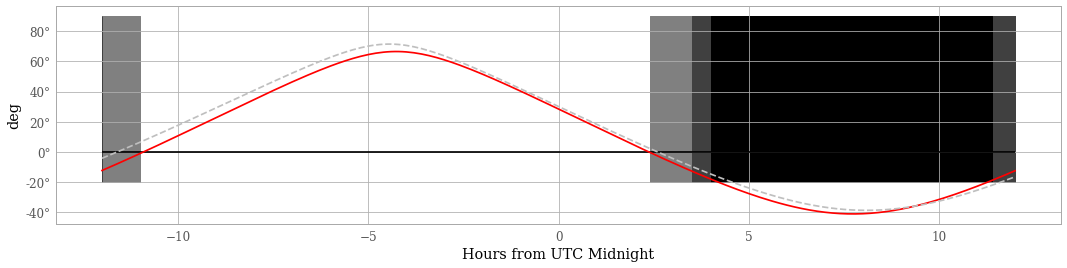

ALL TIMES ARE GIVEN AS UTC TIMES
Local midnight occurs at 2020-08-18 22:59:59.999 UTC
Astronomical twilight and night occurs between 2020-08-18 20:53:59.999 and 2020-08-19 03:29:59.999 UTC
Local astronomical twilight and night occurs between 2020-08-18 21:53:59.999 and 2020-08-19 04:29:59.999 local time


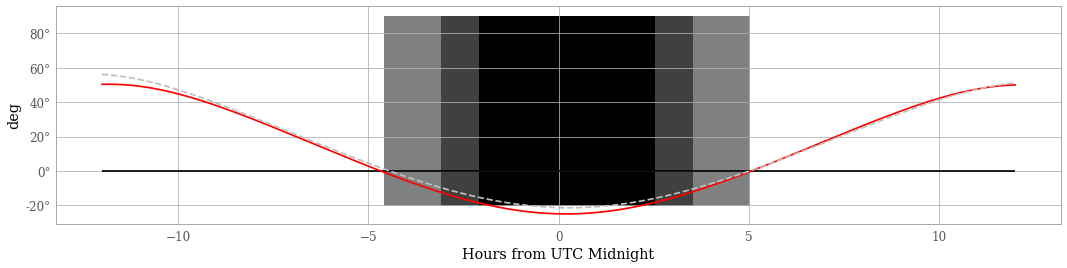

In [7]:
# TRYING TO GET LOCAL TIME TO WORK # 
def sun_moon_tracking(long, lat, alt, date, utc_offset):
    #location = EarthLocation(long, lat, height) #NOTE: West longitudes are negative
    location = EarthLocation(long*u.deg, lat*u.deg, height = alt*u.m)    
    delta_midnight = np.linspace(-12, 12, 241)*u.hour 
    #gives 1 data point every 6mins - each value in the list has dtype: float64
    utc_midnight = Time(f'{date} 23:59:59.999')
    utc_frame_night = AltAz(obstime=utc_midnight+delta_midnight, location=location) 
    #list of times from 15:59:59 til 07:59:59 and list containing location in m, temp, humidity etc
    utc_moon = get_moon(utc_midnight+delta_midnight)
    utc_moon_altaz = utc_moon.transform_to(utc_frame_night)
    utc_sun_altaz = get_sun(utc_midnight+delta_midnight).transform_to(utc_frame_night)
    #sun and moon have format:  SkyCoord YYYY-MM-DD hh:mm:ss.sss
    #                                    ra(deg), dec(deg), distance(AU)
    #sun_altaz has format:      SkyCoord YYYY-MM-DD hh:mm:ss.sss
    #                                    az(deg), alt(deg), distance(m)
    utc_sun_indexlist = []
    for i in range(0, len(utc_sun_altaz)):
        if utc_sun_altaz[i].alt.degree < -12: #ie IF astronomical twilight or astronomical night
            utc_sun_indexlist.append(i)
        else:
            pass
    utc_ast_twi_beg = utc_sun_altaz[utc_sun_indexlist[0]].obstime 
    utc_ast_twi_end = utc_sun_altaz[utc_sun_indexlist[-1]].obstime 
    
    local_midnight = utc_midnight - utc_offset*u.hour #this works for all
    local_ast_twi_beg = utc_sun_altaz[utc_sun_indexlist[0]].obstime + utc_offset*u.hour
    local_ast_twi_end = utc_sun_altaz[utc_sun_indexlist[-1]].obstime + utc_offset*u.hour

    # THIS STUFF WORKS NOW (mostly) #
    print(f'ALL TIMES ARE GIVEN AS UTC TIMES')
    print(f'Local midnight occurs at {local_midnight} UTC')
    print(f'Astronomical twilight and night occurs between {utc_ast_twi_beg} and {utc_ast_twi_end} UTC')
    print(f'Local astronomical twilight and night occurs between {local_ast_twi_beg} and {local_ast_twi_end} local time')
    
    plt.figure(figsize = (18, 4))
    plt.plot(delta_midnight, utc_sun_altaz.alt, color='r', label='Sun')
    plt.plot(delta_midnight, utc_moon_altaz.alt, color=[0.75]*3, ls='--', label='Moon')
    plt.xlabel('Hours from UTC Midnight')
    plt.hlines(0, delta_midnight[0], delta_midnight[-1], label='Local Horizon')
    plt.fill_between(delta_midnight, -20*u.deg, 90*u.deg, utc_sun_altaz.alt < -0*u.deg, color='0.5', zorder=0)
    plt.fill_between(delta_midnight, -20*u.deg, 90*u.deg, utc_sun_altaz.alt < -12*u.deg, color='0.25', zorder=0)
    plt.fill_between(delta_midnight, -20*u.deg, 90*u.deg, utc_sun_altaz.alt < -18*u.deg, color='k', zorder=0)
    #grey area indicates when sun is below the horizon
    #dark grey area indicates when the Sun is between -12 and -18 deg - ie ASTRONOMICAL TWILIGHT 
    #black area indicates when the sun is below -18 deg - ie ASTRONOMICAL NIGHT
    plt.show()
    
    # LOOK AT INDEXING FOR START AND END OF ASTRONOMICAL TWILIGHT #
    # LOOK AT ADDING SECOND X-AXIS FOR LOCAL TIME #
    
    return delta_midnight, utc_moon, utc_moon_altaz, utc_sun_altaz, utc_ast_twi_beg, utc_ast_twi_end


#location = (long, lat,  utc_offset)
las_vegas = (-115.13983, 36.169941, -7)
wast_hills = (-1.944194, 52.387444, +1)
alt = 100
date = '2020-08-18'

S_and_M_LV = sun_moon_tracking(long = float(las_vegas[0]), lat = float(las_vegas[1]), alt = float(alt), date = str(date), utc_offset = las_vegas[2])
#print(f'Astronomical twilight and night occurs between {S_and_M_LV[4]} and {S_and_M_LV[5]} UTC')
    
S_and_M_WH = sun_moon_tracking(long = float(wast_hills[0]), lat = float(wast_hills[1]), alt = float(alt), date = str(date), utc_offset = wast_hills[2])
#print(f'Astronomical twilight and night occurs between {S_and_M_WH[4]} and {S_and_M_WH[5]} UTC')

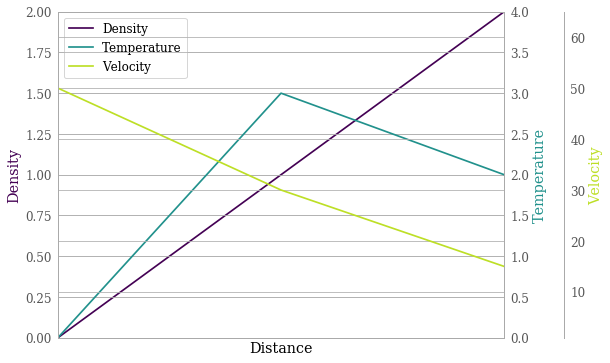

In [8]:
fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()

host.set_xlim(0, 2)
host.set_ylim(0, 2)
par1.set_ylim(0, 4)
par2.set_ylim(1, 65)

host.set_xlabel("Distance")
host.set_ylabel("Density")
par1.set_ylabel("Temperature")
par2.set_ylabel("Velocity")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5)
color3 = plt.cm.viridis(.9)

p1, = host.plot([0, 1, 2], [0, 1, 2], color=color1,label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], color=color2, label="Temperature")
p3, = par2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      
# no x-ticks                 
par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())